In [4]:
#%pip install pandas
#%pip install tesseract

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pytesseract


from page_detection import cleaned_image
#import tensorflow as tf

# Extracting Words

### Load Image

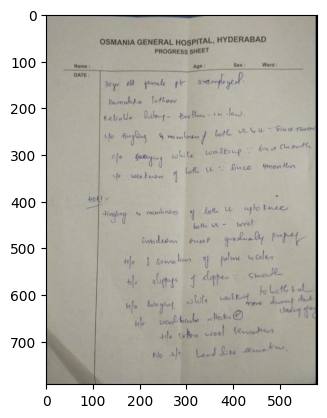

In [6]:
file_ = "Patient_Records/Arthritis/A_0001.jpeg"
img = cleaned_image(file = file_)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert to grayscale to use tesseract
plt.imshow(img);

### Using Default Tesseract

In [7]:
extracted_text = pytesseract.image_to_string(gray)
print(extracted_text)

OSMANIA GENERAL HosPITAL, HYDERABAD
PROGRESS SHEET

Name Age Sex Ware
DATE =

Boyv od 4emale pl Uverrrpl Hh.
v f Md

bamobta lotto

febrale

Lote W

Sines oanbnio y
Bi) Ge ve= wel
waded Propet,

fideo evseh Ff

fief semmbion af fol Sele

[> alegrys 4 “ate Smee

ieee fo Lott: bol
fo bweyiny lite eve dumng dat
leky |

ube woul bcasba take @
le hw wool Sevehar

Breu,

No: 4] Melled Shales


